In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
st = pd.read_csv('data/studentInfo.csv')

In [3]:
st.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


**StudentInfo Dataset description**
* There are 32953 rows in the dataset, but only **28785 unique students**
* 52% of students are male, 48% of students are female
* 84% of students level of education is A level or below
* 70% of student are 35 or under, 29% is between 35 and 55, the remaining 1% is above the age of 55 
* 10% of students have a disability

Due to some student repeating modules, for the initial demographic analysis I will remove their duplicate information and only keep one record per student.

In [6]:
st.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
code_module             32593 non-null object
code_presentation       32593 non-null object
id_student              32593 non-null int64
gender                  32593 non-null object
region                  32593 non-null object
highest_education       32593 non-null object
imd_band                31482 non-null object
age_band                32593 non-null object
num_of_prev_attempts    32593 non-null int64
studied_credits         32593 non-null int64
disability              32593 non-null object
final_result            32593 non-null object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB


In [4]:
#dropping multiple records from the dataset
st_clean = pd.DataFrame.drop_duplicates (st, subset = 'id_student')

M    0.522703
F    0.477297
Name: gender, dtype: float64

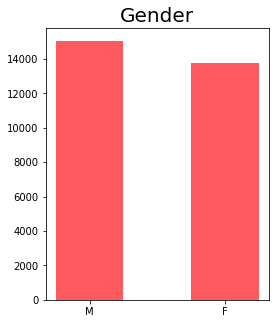

In [20]:
#plt.figure(figsize=(6,6))
#plt.title('Student Gender')
#plt.hist(st.highest_education,rwidth=5);

def plot_cat_var(column,title,size=(10,6)):
    new_d = dict(column.value_counts())
    d_keys = list(new_d.keys())
    d_values = list(new_d.values())

    plt.figure(figsize=size)
    plt.bar(d_keys, d_values,color='#ff5a5f', width=0.5)
    plt.title(title,fontsize=20)

plot_cat_var(st_clean.gender,'Gender',size=(4,5))
st_clean.gender.value_counts(normalize=True)

A Level or Equivalent          0.429217
Lower Than A Level             0.409241
HE Qualification               0.142157
No Formal quals                0.010631
Post Graduate Qualification    0.008755
Name: highest_education, dtype: float64

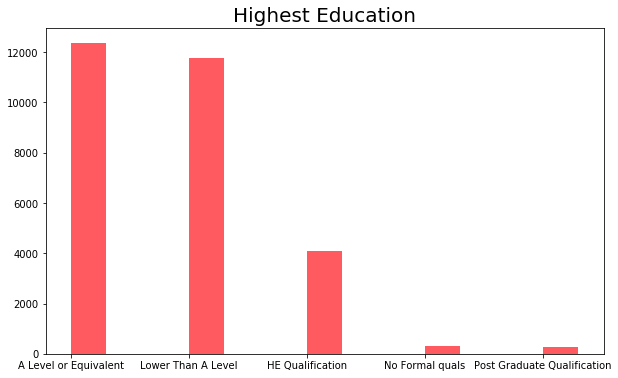

In [18]:
plot_cat_var(st_clean.highest_education,'Highest Education')
st_clean.highest_education.value_counts(normalize=True)

0-35     0.699844
35-55    0.293973
55<=     0.006184
Name: age_band, dtype: float64

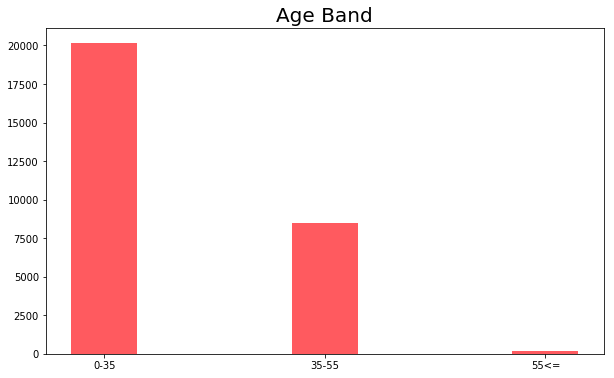

In [13]:
plot_cat_var(st_clean.age_band,'Age Band')
st_clean.age_band.value_counts(normalize=True)

N    0.905611
Y    0.094389
Name: disability, dtype: float64

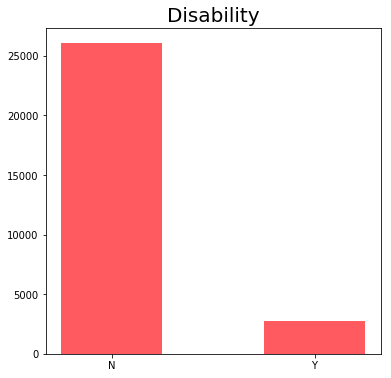

In [7]:
plot_cat_var(st_clean.disability,'Disability',size=(6,6))
st_clean.disability.value_counts(normalize=True)

**Final Results**
* 38% of students have finished their modules + 10% with a distinction
* 31% have withdrawn from a module
* 21% of students failed
* OPTION OF ANALYSIS - DOES THE AMOUNT OF INTERACTIONS EFFECT OF GETTING A DISTINCTION?

Pass           0.376342
Withdrawn      0.314157
Fail           0.217613
Distinction    0.091888
Name: final_result, dtype: float64

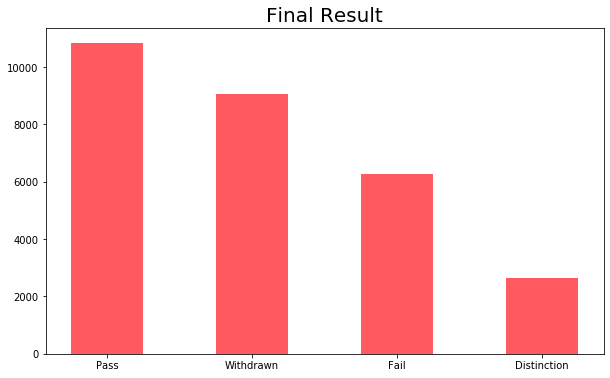

In [26]:
plot_cat_var(st_clean.final_result,'Final Result')
st_clean.final_result.value_counts(normalize=True)

Pass           0.379253
Withdrawn      0.311601
Fail           0.216365
Distinction    0.092781
Name: final_result, dtype: float64

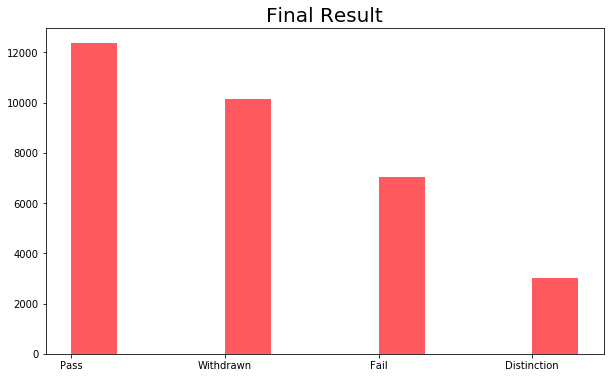

In [19]:
plot_cat_var(st.final_result,'Final Result')
st.final_result.value_counts(normalize=True)

In [21]:
vle = pd.read_csv('data/studentVle.csv')

In [22]:
vle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [28]:
len(vle.id_student.unique())
unique_vle_students = list(vle.id_student.unique())
unique_total_students = list(st_clean.id_student.unique())

In [36]:
#26074 unique students have interacted with the VLE
#but there are 28785 unique students - it seems like there might be 2711 students who have not used
#the VLE

In [61]:
#let's find you which students are not in the VLE table
unique_vle_students = set(vle.id_student)
unique_total_students = set(st_clean.id_student)

#this is a list of students who are not present in VLE df
students_not_in_vle = list(unique_total_students.difference(unique_vle_students))

#this is a dataframe with information about students who are not present in the VLE df
df_not_in_vle = st_clean[st_clean.id_student.isin(students_not_in_vle)]

Withdrawn    0.879749
Fail         0.119144
Pass         0.001107
Name: final_result, dtype: float64

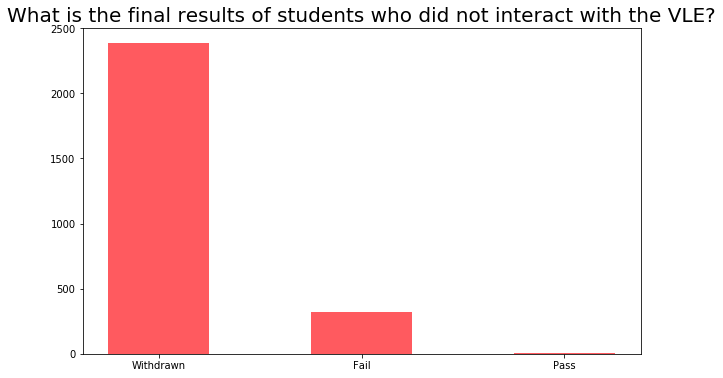

In [63]:
plot_cat_var(df_not_in_vle.final_result,'What is the final results of students who did not interact with the VLE?')
df_not_in_vle.final_result.value_counts(normalize=True)

In [ ]:
# it seems like the students who have not the VLE at all have mostly withdrawn from the module
# this suggest that these are the students who have changed their mind
# however, here is 12% of students who failed their module in this dataset
#DECIDE WHAT TO DO ABOUT THIS

In [64]:
vle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [135]:
#creating a df with the total number of clicks in VLE per student
df_sum_click = vle.groupby('id_student').sum()
df_sum_click.drop(['id_site','date'], axis=1, inplace=True)

In [136]:
df_sum_click.head()

,sum_click
id_student,
6516,2791
8462,656
11391,934
23629,161
23698,910


In [137]:
#I will now join this table with the main table of students

In [138]:
st_with_total_clicks = st_clean.set_index('id_student')

In [139]:
st_with_total_clicks = st_with_total_clicks.join(df_sum_click)

In [140]:
st_with_total_clicks.isna().sum()

code_module                0
code_presentation          0
gender                     0
region                     0
highest_education          0
imd_band                 971
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
sum_click               2711
dtype: int64

In [141]:
st_with_total_clicks.sum_click = st_with_total_clicks.sum_click.fillna(0)

In [142]:
#now we have a dataframe with all students including their total number of VLE interactions

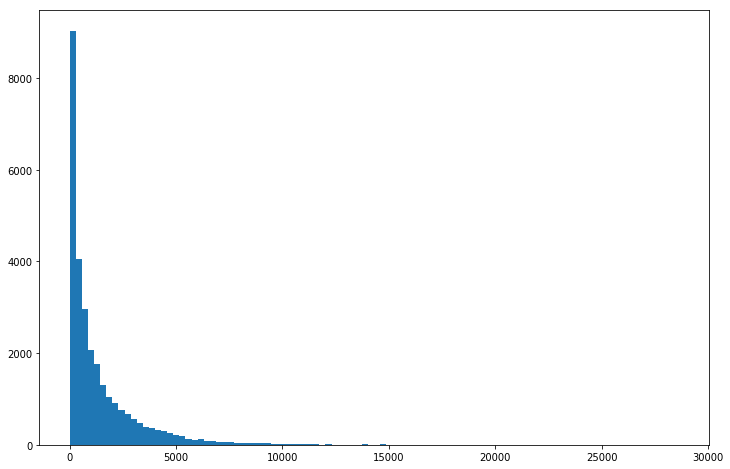

In [143]:
plt.figure(figsize=(12,8))
plt.hist(st_with_total_clicks.sum_click, bins=100);

In [144]:
#try plotting average grade with num_clicks

In [145]:
assessment = pd.read_csv('data/studentAssessment.csv')

In [146]:
assessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [147]:
assessment.dropna(inplace=True)

In [154]:
assessment.isna().sum()

score    0
dtype: int64

In [156]:
len(assessment)

23351

In [148]:
assessment = assessment.groupby('id_student').median()

In [149]:
assessment.drop(['id_assessment','date_submitted','is_banked'],axis=1, inplace=True)

In [150]:
assessment.head()

,score
id_student,
6516,61.0
8462,87.0
11391,82.0
23629,83.5
23698,73.0


In [151]:
st_with_total_clicks = st_with_total_clicks.join(assessment)

In [152]:
st_with_total_clicks.head()

,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,sum_click,score
id_student,,,,,,,,,,,,,
11391,AAA,2013J,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,934.0,82.0
28400,AAA,2013J,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,1435.0,68.0
30268,AAA,2013J,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,281.0,NaN
31604,AAA,2013J,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,2158.0,74.0
32885,AAA,2013J,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,1034.0,63.0


In [153]:
st_with_total_clicks.isna().sum()

code_module                0
code_presentation          0
gender                     0
region                     0
highest_education          0
imd_band                 971
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
sum_click                  0
score                   5434
dtype: int64

In [155]:
len(st_with_total_clicks)

28785

In [ ]:
#INVESTIGATE WHY THE DIFFERENCE - WHY IS THERE SMALLER NUMBER OF STUDENTS IN ASSESSMENT THAN IN 
#TOTAL TABLE